<a href="https://colab.research.google.com/github/rhilderbrand/MSDS-422-MachineLearning/blob/main/Hilderbrand_Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 7: Image Processing with a CNN

We will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow. 

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition 

Specifically, you will build models using the training set to forecast the test set. The images are in .jpg format, so you will need to research how to handle that.  You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation.

**Kaggle Username:** beccahilderbrand

In [ ]:
!pip install tflearn

     |████████████████████████████████| 112kB 6.9MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=e68ef6197bcbacedcf4591bbaf3f3308ac013a8d7eaf457990206004bb026d04
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals, absolute_import

# Common imports for our work
import os 
import os.path  # for manipulation of file path names
import numpy as np
import tensorflow as tf
import time
import re

# loading zip files
import zipfile

# working with images
import cv2

# for display of images
from matplotlib import pyplot as plt
#from matplotlib import imshow
import seaborn as sns

import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

from skimage import color, io
from sklearn.model_selection import train_test_split
from glob import glob

import logging
logging.getLogger('tensorflow').disabled = True

from tqdm import tqdm

RANDOM_SEED = 9999

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [ ]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/Colab Notebooks/Week 7/
!pwd
!ls
print('Working Directory')
print(os.getcwd())

work_dir = " /content/gdrive/My Drive/Colab Notebooks/Week 7/"

/content/gdrive/My Drive/Colab Notebooks/Week 7
/content/gdrive/My Drive/Colab Notebooks/Week 7
checkpoint		     Hilderbrand_Assignment_7_v3	   tmp
Hilderbrand_Assignment_7     run-cats-dogs-jump-start-dnn-v002.py  train.zip
Hilderbrand_Assignment_7_v2  test.zip
Working Directory
/content/gdrive/My Drive/Colab Notebooks/Week 7


In [ ]:
# one-hot encoding
def label_img(img_name):
  if 'cat' in img_name: return [1, 0]
  elif 'dog' in img_name: return [0, 1]

In [ ]:
# Image Dimensions for 64x64 input
height = 64
width = 64

# Image Dimensions for 128x128 input
#height = 128
#width = 128

# use channel=1 for grayscale and channel=3 for color
channel = 1 

# define image shape and length from defined dimensions
img_shape = [width, height]
img_length = width*height

In [ ]:
# load the training dataset from google drive
training_data = []

with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Week 7/train.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (width, height))

      training_data.append([ np.array(img), np.array(label)])

100%|██████████| 25000/25000 [00:42<00:00, 593.98it/s]


In [ ]:
# explore dataset
training_data[0]

[array([[170, 176, 183, ..., 216, 211, 206],
        [170, 176, 183, ..., 218, 214, 209],
        [170, 176, 183, ..., 218, 217, 212],
        ...,
        [130, 134, 137, ...,   3,   3,   2],
        [128, 130, 133, ...,   3,   3,   2],
        [125, 129, 132, ...,   2,   2,   2]], dtype=uint8), array([1, 0])]

In [ ]:
def peek_img( index, data = training_data):
  img_type = 'Unknown'
  
  if np.array_equal(data[index][1], [1, 0]): img_type = 'Cat'
  elif np.array_equal(data[index][1], [0, 1]): img_type = 'Dog'
  
  plt.imshow(data[index][0], cmap = 'gray', interpolation = 'bicubic')
  plt.title(img_type)
  plt.show()

In [ ]:
# look at first image in the training dataset
training_data[0][0]

array([[170, 176, 183, ..., 216, 211, 206],
       [170, 176, 183, ..., 218, 214, 209],
       [170, 176, 183, ..., 218, 217, 212],
       ...,
       [130, 134, 137, ...,   3,   3,   2],
       [128, 130, 133, ...,   3,   3,   2],
       [125, 129, 132, ...,   2,   2,   2]], dtype=uint8)

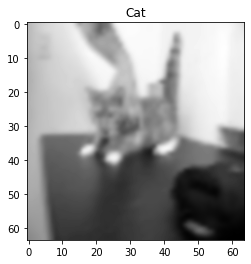

In [ ]:
peek_img(0)

In [ ]:
dog_index = -1

for i, x in enumerate(training_data):
  if np.array_equal(x[1], [0, 1]):
    dog_index = i
    break

dog_index

12500

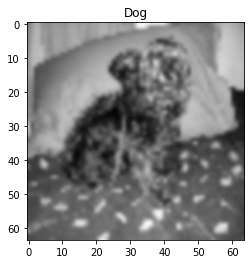

In [ ]:
peek_img(dog_index)

In [ ]:
# display random images and their labels from training set
def plot_images(images, cls_true, indexes = None, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=1.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis, and the image index on the y-axis.
        ax.set_xlabel(xlabel)
        
        if indexes != None:
          ax.set_ylabel(indexes[i])
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
def plot_indexes(indexes):
  subset = [training_data[i] for i in indexes]

  images = []
  labels = []

  for i in subset:
    x, y = i

    images.append(x)

    if np.array_equal(y, [1, 0]): labels.append('Cat')
    elif np.array_equal(y, [0, 1]): labels.append('Dog')

  plot_images(images, labels, indexes)

In [ ]:
# get random indices
import random

indexes = []

for x in range(9):
  indexes.append(random.randint(0, len(training_data)))

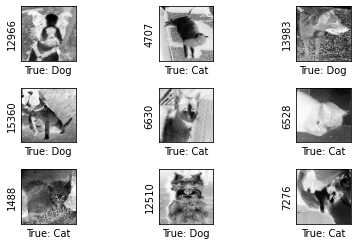

In [ ]:
plot_indexes(indexes)

In [ ]:
from random import shuffle 

shuffle(training_data)

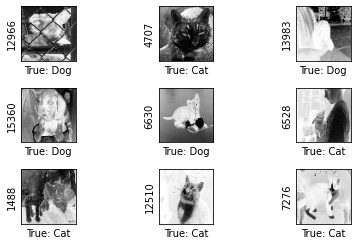

In [ ]:
# ensure shuffling worked
plot_indexes(indexes)

##Split Training Data

In [ ]:
# 80/20 train test split
train_size = int(len(training_data) * .8)
train_size

20000

In [ ]:
# ensure proper split
train = training_data[-train_size:]
display('Train Size: {}'.format(len(train)))

test = training_data[:-train_size]
display('Test Size: {}'.format(len(test)))

'Train Size: 20000'

'Test Size: 5000'

In [ ]:
# Train data
X_train = np.array([i[0] for i in train]).reshape(-1,width,height,1)
y_train = np.array([i[1] for i in train])

# Test data
X_test = np.array([i[0] for i in test]).reshape(-1,width,height,1)
y_test = np.array([i[1] for i in test])

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 64, 64, 1)
(20000, 2)
(5000, 64, 64, 1)
(5000, 2)


##Define Model Architecture

### Model 1a - 3 Convolutional Layers, 50% dropout rate

In [ ]:
# input is 64x64 image using grayscale
convnet = input_data(shape=[None, width, height, 1], name='input')

# Convolution layer with 32 filters
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 64 filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 128 filters
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Fully-connected 1024 node layer
convnet = fully_connected(convnet, 1024, activation='relu')

# dropout layer to combat overfitting set to 80 percent dropout rate
convnet = dropout(convnet, 0.5)

# Fully-connected layer with two outputs
convnet = fully_connected(convnet, 2, activation='softmax')

# Configure how the network will be trained
convnet = regression(convnet, optimizer='adam', learning_rate=1e-3, loss='categorical_crossentropy', name='targets')

# wrap network in a model object
model_1a = tflearn.DNN(convnet, tensorboard_dir='tmp/tflearn_logs/')

In [ ]:
reset_graph()

start_time = time.clock()

model_1a.fit(X_train, y_train, n_epoch=3, 
             validation_set=(X_test, y_test), 
             snapshot_step=500, show_metric=True,
             run_id='model_1a')

end_time = time.clock()

runtime = end_time - start_time  # seconds of wall-clock time

Training Step: 938  | total loss: 0.68545 | time: 97.534s
| Adam | epoch: 003 | loss: 0.68545 - acc: 0.5527 -- iter: 19968/20000
Training Step: 939  | total loss: 0.68598 | time: 103.106s
| Adam | epoch: 003 | loss: 0.68598 - acc: 0.5522 | val_loss: 0.69454 - val_acc: 0.4914 -- iter: 20000/20000
--


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
display('Model 1a Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model 1a Train Time: 5.36 minutes'

###Model 1b - 3 Convolutional Layers, 80% dropout rate

In [ ]:
# input is 64x64 image using grayscale
convnet = input_data(shape=[None, width, height, 1], name='input')

# Convolution layer with 32 filters
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 64 filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 128 filters
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Fully-connected 1024 node layer
convnet = fully_connected(convnet, 1024, activation='relu')

# dropout layer to combat overfitting set to 80 percent dropout rate
convnet = dropout(convnet, 0.8)

# Fully-connected layer with two outputs
convnet = fully_connected(convnet, 2, activation='softmax')

# Configure how the network will be trained
convnet = regression(convnet, optimizer='adam', learning_rate=1e-3, loss='categorical_crossentropy', name='targets')

# wrap network in a model object
model_1b = tflearn.DNN(convnet, tensorboard_dir='tmp/tflearn_logs/')

In [ ]:
reset_graph()

start_time = time.clock()

model_1b.fit(X_train, y_train, n_epoch=3, validation_set=(X_test, y_test), 
             batch_size=500, show_metric=True, run_id='model_1b')

end_time = time.clock()

runtime = end_time - start_time  # seconds of wall-clock time

Training Step: 119  | total loss: 11.31953 | time: 81.488s
| Adam | epoch: 003 | loss: 11.31953 - acc: 0.5084 -- iter: 19500/20000
Training Step: 120  | total loss: 11.30202 | time: 88.538s
| Adam | epoch: 003 | loss: 11.30202 - acc: 0.5092 | val_loss: 11.72937 - val_acc: 0.4906 -- iter: 20000/20000
--


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [ ]:
display('Model 1b Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model 1b Train Time: 5.0 minutes'

### Model 2a - 5 Convolutional Layers, 50% dropout rate

In [ ]:
# input is 64x64 image using grayscale
convnet = input_data(shape=[None, width, height, 1], name='input')

# Convolution layer with 32 filters
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 64 filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 128 filters
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 64 filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 32 filters
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Fully-connected 1024 node layer
convnet = fully_connected(convnet, 1024, activation='relu')

# dropout layer to combat overfitting set to 80 percent dropout rate
convnet = dropout(convnet, 0.5)

# Fully-connected layer with two outputs
convnet = fully_connected(convnet, 2, activation='softmax')

# Configure how the network will be trained
convnet = regression(convnet, optimizer='adam', learning_rate=1e-3, loss='categorical_crossentropy', name='targets')

# wrap network in a model object
model_2a = tflearn.DNN(convnet, tensorboard_dir='tmp/tflearn_logs/')

In [ ]:
reset_graph()

start_time = time.clock()

model_2a.fit(X_train, y_train, validation_set=(X_test, y_test), n_epoch=3,
            batch_size=500, show_metric=True, run_id='model_2a')

end_time = time.clock()

runtime = end_time - start_time  # seconds of wall-clock time

Training Step: 119  | total loss: 0.55168 | time: 89.495s
| Adam | epoch: 003 | loss: 0.55168 - acc: 0.7231 -- iter: 19500/20000
Training Step: 120  | total loss: 0.54863 | time: 96.835s
| Adam | epoch: 003 | loss: 0.54863 - acc: 0.7258 | val_loss: 0.54923 - val_acc: 0.7300 -- iter: 20000/20000
--


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [ ]:
display('Model 2a Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model 2a Train Time: 5.29 minutes'

###Model 2b - 5 Convolutional Layers, 80% dropout rate

In [ ]:
# input is 64x64 image using grayscale
convnet = input_data(shape=[None, width, height, 1], name='input')

# Convolution layer with 32 filters
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 64 filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 128 filters
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 64 filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Convolution layer with 32 filters
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# Fully-connected 1024 node layer
convnet = fully_connected(convnet, 1024, activation='relu')

# dropout layer to combat overfitting set to 80 percent dropout rate
convnet = dropout(convnet, 0.8)

# Fully-connected layer with two outputs
convnet = fully_connected(convnet, 2, activation='softmax')

# Configure how the network will be trained
convnet = regression(convnet, optimizer='adam', learning_rate=1e-3,
                     loss='categorical_crossentropy', name='targets')

# wrap network in a model object
model_2b = tflearn.DNN(convnet, tensorboard_dir='tmp/tflearn_logs/')

In [ ]:
reset_graph()

start_time = time.clock()

model_2b.fit(X_train, y_train, validation_set=(X_test, y_test), n_epoch=3,
             batch_size=500, show_metric=True, run_id='model_2b')

end_time = time.clock()

runtime = end_time - start_time  # seconds of wall-clock time

Training Step: 119  | total loss: 0.57786 | time: 90.558s
| Adam | epoch: 003 | loss: 0.57786 - acc: 0.6891 -- iter: 19500/20000
Training Step: 120  | total loss: 0.57470 | time: 98.020s
| Adam | epoch: 003 | loss: 0.57470 - acc: 0.6924 | val_loss: 0.56642 - val_acc: 0.7018 -- iter: 20000/20000
--


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [ ]:
display('Model 2b Train Time: {} minutes'.format(round(runtime / 100, 2)))

'Model 2b Train Time: 5.31 minutes'

##Validation

In [ ]:
# load test data
test_data = []

with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Week 7/test.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (width, height))

      test_data.append([ np.array(img), np.array(label)])

100%|██████████| 12500/12500 [00:20<00:00, 617.24it/s]


##Visual Inspection

In [ ]:
def visual_inspect_model(model):
  fig=plt.figure(figsize=(5,5))
  fig.subplots_adjust(hspace=0.5, wspace=1.3)

  for num,data in enumerate(test_data[:12]):

      img_num = data[1]
      img_data = data[0]

      y = fig.add_subplot(4,3,num+1)
      orig = img_data
      data = img_data.reshape(width,height,1)

      model_out = model.predict([data])[0]

      if np.argmax(model_out) == 1: str_label='Dog'
      else: str_label='Cat'

      y.imshow(orig,cmap='gray')
      plt.title(str_label)
      y.axes.get_xaxis().set_visible(False)
      y.axes.get_yaxis().set_visible(False)

  plt.show()

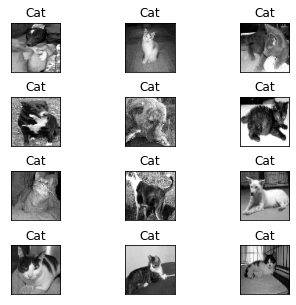

In [ ]:
visual_inspect_model(model_1a)

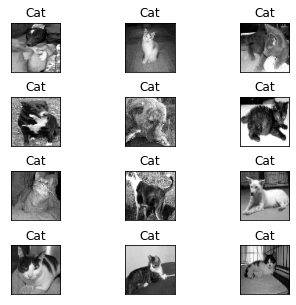

In [ ]:
visual_inspect_model(model_1b)

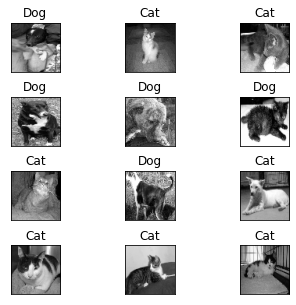

In [ ]:
visual_inspect_model(model_2a)

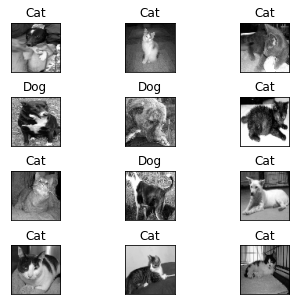

In [ ]:
visual_inspect_model(model_2b)

##Test Data Summary

In [ ]:
def validate_model(model):
  total = len(X_test)
  correct = 0

  for num, data in enumerate(X_test):
    y_pred = model.predict([data])[0]

    if np.argmax(y_pred) == 1: img_pred='Dog'
    else: img_pred='Cat'

    if np.array_equal(y_test[num], [1, 0]): img_actual = 'Cat'
    elif np.array_equal(y_test[num], [0, 1]): img_actual = 'Dog'

    if img_actual == img_pred:
      correct = correct + 1

  display('Total Test Images: {}, Correctly Predicted: {}, {:.2%}'.format(total, correct, correct / total))

In [ ]:
validate_model(model_1a)

'Total Test Images: 5000, Correctly Predicted: 2457, 49.14%'

In [ ]:
kag_df1a = pd.DataFrame(y_pred, columns= ['label']).reset_index()
kag_df1a['index'] = kag_df1a.index + 1
kag_df1a.rename(columns ={'index':'id'}, inplace=True)
kag_df1a.head()

In [ ]:
kag_df1a.to_csv('Hilderbrand_CNN_Predictions_1a.csv')

In [ ]:
validate_model(model_1b)

'Total Test Images: 5000, Correctly Predicted: 2453, 49.06%'

In [ ]:
validate_model(model_2a)

'Total Test Images: 5000, Correctly Predicted: 3650, 73.00%'

In [ ]:
validate_model(model_2b)

'Total Test Images: 5000, Correctly Predicted: 3509, 70.18%'